<a href="https://colab.research.google.com/github/rafflds/Transfer_Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DESCRIÇÃO
O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB. Neste projeto, você pode usar sua própria base de dados (exemplo: fotos suas, dos seus pais, dos seus amigos, dos seus animais domésticos, etc), o exemplo de gatos e cachorros, pode ser substituído por duas outras classes do seu interesse. O Dataset criado em nosso projeto anterior, pode ser utilizado agora.

## Bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Exemplo de modelo pré-treinado
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os


## Preparação do Dataset

In [3]:
# --- Configurações Principais ---
DATASET_PATH = "/content/Projeto"  # caminho da pasta com as imagens
IMAGE_SIZE = (224, 224)  # Tamanho padrão para modelos pré-treinados
BATCH_SIZE = 32  # Tamanho do lote para treinamento
VALIDATION_SPLIT = 0.2  # Proporção dos dados para validação

# --- 1.1. Verificação do Caminho ---
if not os.path.exists(DATASET_PATH):
    print(f"Erro: O caminho do dataset '{DATASET_PATH}' não existe. Verifique se o caminho está correto e se as pastas de países estão dentro.")
    exit() # Aborta a execução caso o caminho não exista



# Gerar imagens adicionais durante o treino
datagen = ImageDataGenerator(
    rescale=1./255,      # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=20,  # Rotaciona as imagens aleatoriamente
    width_shift_range=0.2, # Desloca horizontalmente as imagens aleatoriamente
    height_shift_range=0.2, # Desloca verticalmente as imagens aleatoriamente
    shear_range=0.2,      # Aplica transformações de cisalhamento
    zoom_range=0.2,       # Aplica zoom aleatório
    horizontal_flip=True, # Inverte horizontalmente as imagens
    fill_mode='nearest',  # Preenche pixels recém criados (ex: em rotações)
    validation_split=VALIDATION_SPLIT # Reserva uma porção dos dados para validação
)

# Carrega os dados de treinamento
train_generator = datagen.flow_from_directory(
    DATASET_PATH,            # Caminho para a pasta principal
    target_size=IMAGE_SIZE,  # Redimensiona para o tamanho desejado
    batch_size=BATCH_SIZE,    # Tamanho do lote de imagens por vez
    class_mode='categorical', # Modo de classificação (varias classes)
    subset='training'       # Indica que são dados de treino
)


# Carrega os dados de validação
val_generator = datagen.flow_from_directory(
    DATASET_PATH,            # Caminho para a pasta principal
    target_size=IMAGE_SIZE,  # Redimensiona para o tamanho desejado
    batch_size=BATCH_SIZE,    # Tamanho do lote de imagens por vez
    class_mode='categorical', # Modo de classificação
    subset='validation'      # Indica que são dados de validação
)

# --- 1.3. Exibição de Informações ---
num_classes = len(train_generator.class_indices)
print(f"Número de classes (Raio-X): {num_classes}")

print("Imagens de treinamento:")
print(f"- Quantidade de lotes: {len(train_generator)}")
print(f"- Total de imagens: {train_generator.n}")

print("Imagens de validação:")
print(f"- Quantidade de lotes: {len(val_generator)}")
print(f"- Total de imagens: {val_generator.n}")

Found 310 images belonging to 3 classes.
Found 76 images belonging to 3 classes.
Número de classes (Raio-X): 3
Imagens de treinamento:
- Quantidade de lotes: 10
- Total de imagens: 310
Imagens de validação:
- Quantidade de lotes: 3
- Total de imagens: 76


## Visualizar imagens

Visualizando imagens de treinamento:


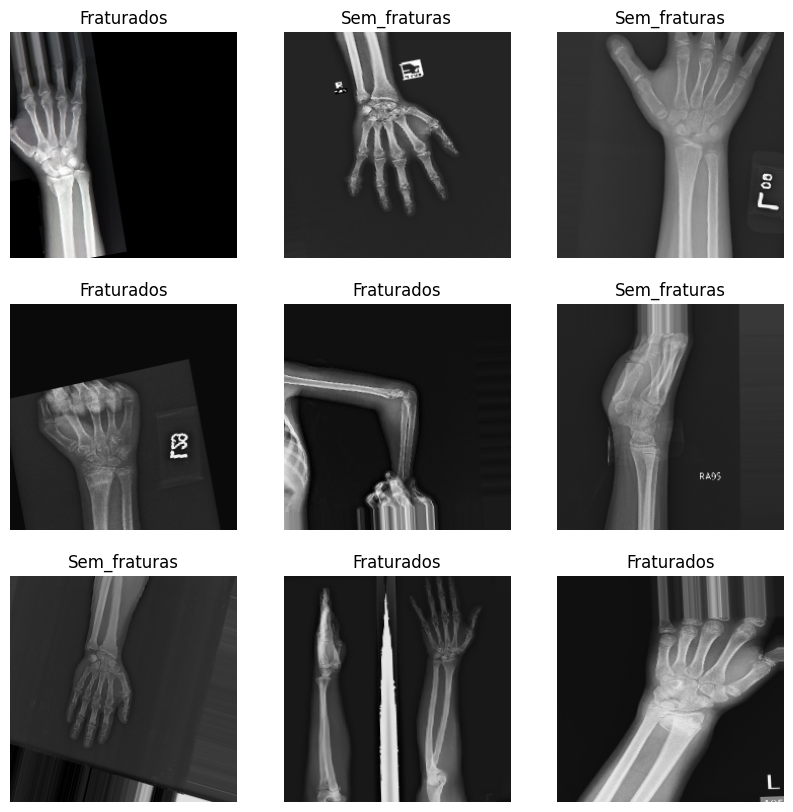

Visualizando imagens de validação:


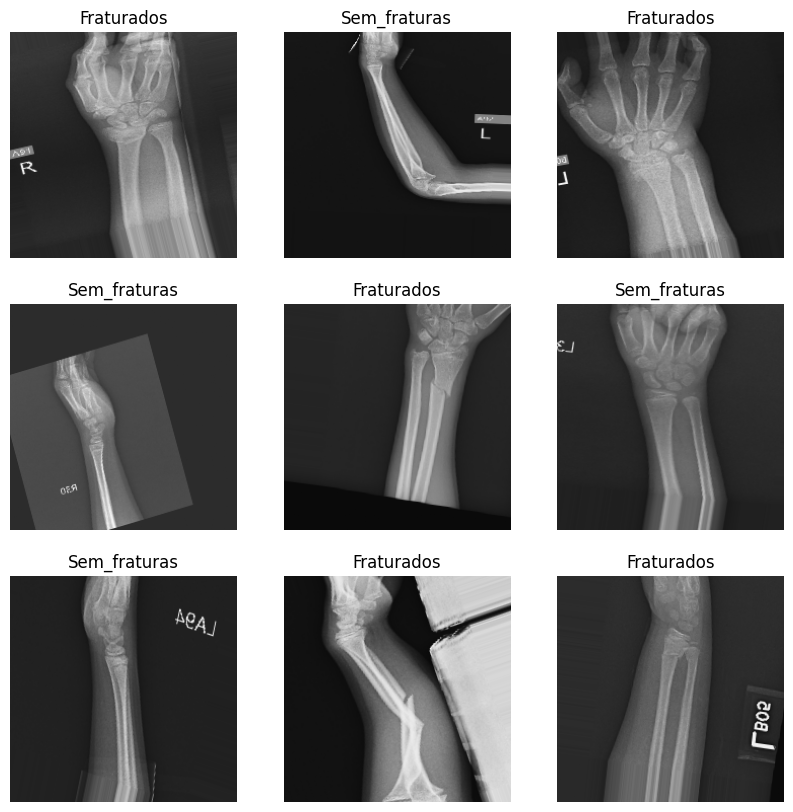

In [8]:
def visualize_images(generator, num_images=9):
    """Visualiza um lote de imagens do gerador."""
    images, labels = next(generator)  # Obtém um lote de imagens e rótulos
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        # Get label of the image, if exists
        try:
          label_index = np.argmax(labels[i])
          label = list(generator.class_indices.keys())[list(generator.class_indices.values()).index(label_index)]
          plt.title(label)
        except:
          pass
        plt.axis("off")
    plt.show()


# Visualizar imagens de treinamento
print("Visualizando imagens de treinamento:")
visualize_images(train_generator)

# Visualizar imagens de validação
print("Visualizando imagens de validação:")
visualize_images(val_generator)


## Modelo Pré-Treinado (VGG16 como exemplo)

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# ... (rest of your code)
# 3. Adaptação e Treinamento
for layer in base_model.layers:
    layer.trainable = False

# Adiciona camadas para classificação
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduz a dimensionalidade
x = Dense(1024, activation='relu')(x)
num_classes = len(train_generator.class_indices)
predictions = Dense(num_classes, activation='softmax')(x) # Camada de saída com nº de países

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10 # Ajustar nº de épocas conforme necessário
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.4407 - loss: 0.9614 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 255s 26s/step - accuracy: 0.4490 - loss: 0.9457 - val_accuracy: 0.5263 - val_loss: 0.6920
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 246s 24s/step - accuracy: 0.6433 - loss: 0.6548 - val_accuracy: 0.3816 - val_loss: 0.7515
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 284s 29s/step - accuracy: 0.5467 - loss: 0.6689 - val_accuracy: 0.6711 - val_loss: 0.6555
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 283s 24s/step - accuracy: 0.7086 - loss: 0.6119 - val_accuracy: 0.6053 - val_loss: 0.6561
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 249s 25s/step - accuracy: 0.7576 - loss: 0.5533 - val_accuracy: 0.4737 - val_loss: 0.7268
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 246s 24s/step - accuracy: 0.6673 - loss: 0.5955 - val_accuracy: 0.6184 - val_loss: 0.6580
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 245s 24s/step - accuracy: 0.7193 - loss: 0.5575 - val_accuracy: 0.6316 - val_loss: 0.6707
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 243s 24s/step - accuracy: 0.6834 - loss: 0.5560 - val_accuracy: 0.6447 - val_

## Avaliação e Visualização (trecho)

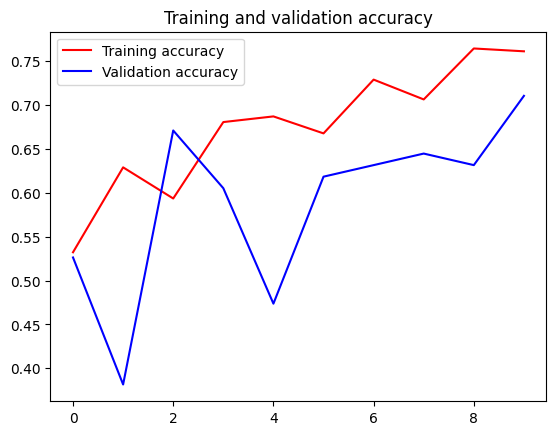

<Figure size 640x480 with 0 Axes>

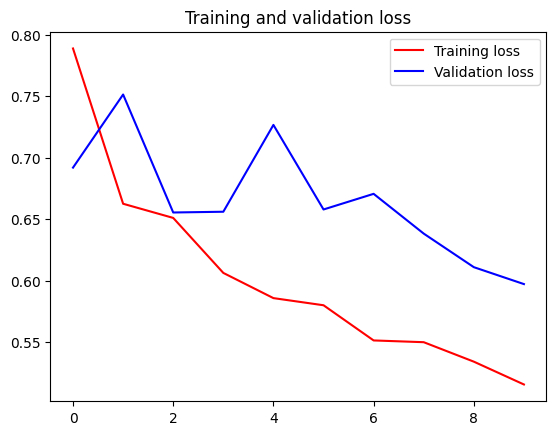

modelo salvo!


In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

# 5. Uso e Persistência
model.save('modelo_paises.h5')

print ("modelo salvo!")